In [1]:
import pandas as pd
from upgrade import *
from causallearn.utils.cit import CIT
import numpy as np
from pathlib import Path
import os
from tqdm import tqdm

dataname = "asia"
# dataname = "erdos_renyi/d40_p0.1"
mi = 3      # The number of values a variable can take is ranged in [2, mi-1]
di = 1      # The dirichlet alpha that controls the data distribution
n = 10      # The number of data silos

silos = []

folderpath = f"./data/distributed/{dataname}/m{mi}_d{di}_n{n}"
groundtruth = np.loadtxt(f"./data/distributed/{dataname}/adj.txt")

if not Path(folderpath).exists():
    print("Folder", folderpath, "not exist!")
else:
    for file in sorted(os.listdir(folderpath)):
        filename = os.path.join(folderpath, file)
        silo_data = pd.read_csv(filename)
        silos.append(silo_data)
        print("Loaded file:", filename, end="\t")
        print(len(silo_data), " Instances", len(silo_data.columns), "Variables")

merged_df = pd.concat(silos, axis=0)
print("Observational data:", len(merged_df))
# intervened_df = silos[-1]
# print("Interventional data:", len(intervened_df))

merged_df = merged_df.reindex(sorted(merged_df.columns, key=lambda item: int(item[1:])), axis=1)
# intervened_df = intervened_df.reindex(sorted(intervened_df.columns, key=lambda item: int(item[1:])), axis=1)

all_vars = list(merged_df.columns)

Loaded file: ./data/distributed/asia/m3_d1_n10/silo-0.csv	5000  Instances 8 Variables
Loaded file: ./data/distributed/asia/m3_d1_n10/silo-1.csv	5000  Instances 8 Variables
Loaded file: ./data/distributed/asia/m3_d1_n10/silo-2.csv	5000  Instances 8 Variables
Loaded file: ./data/distributed/asia/m3_d1_n10/silo-3.csv	5000  Instances 8 Variables
Loaded file: ./data/distributed/asia/m3_d1_n10/silo-4.csv	5000  Instances 8 Variables
Loaded file: ./data/distributed/asia/m3_d1_n10/silo-5.csv	5000  Instances 8 Variables
Loaded file: ./data/distributed/asia/m3_d1_n10/silo-6.csv	5000  Instances 8 Variables
Loaded file: ./data/distributed/asia/m3_d1_n10/silo-7.csv	5000  Instances 8 Variables
Loaded file: ./data/distributed/asia/m3_d1_n10/silo-8.csv	5000  Instances 8 Variables
Loaded file: ./data/distributed/asia/m3_d1_n10/silo-9.csv	5000  Instances 8 Variables
Observational data: 50000


In [2]:
def univariate_sampling(data: pd.DataFrame, variable: str, sample_dis: dict):
    """
    This function create a new data frame from the input data frame
    By sampling single variable following the input sample distribution
    
    Arguments:
        variable:   str
        sample_dis: dict {'value': prob}
    
    Return:
        new_data: pd.DataFrame
    """
    coc = data[variable].to_numpy().flatten()             # Column of Concern (variable column)
    vals = [val for val in sample_dis.keys()]
    counts = np.array([np.sum(coc == val) for val in sample_dis.keys()])
    probs = np.array([p for p in sample_dis.values()])
    num_selects = np.floor(min(counts/probs) * probs).flatten()
        
    all_index = []
    for val, num_select in zip(vals, num_selects):
        all_index += list(np.random.choice(list(np.where(coc==val)[0]), size=int(num_select), replace=False))
    
    res = data.iloc[all_index].reset_index()
    return res.drop(columns=['index']), all_index


def multivariate_sampling(data: pd.DataFrame, variables: list, sample_dis: dict, instance_index):
    remains = deepcopy(variables)
    while len(remains):
        sampling_var = remains.pop(0)
        distribution = sample_dis[sampling_var][instance_index]
        df, all_index = univariate_sampling(data, sampling_var, {i: distribution[i] for i in range(distribution.shape[0])})
    return df

In [3]:
def conditional_distribution(df: pd.DataFrame, variable,  conditioned_variables: list):
    vertical_sampled_data = df[conditioned_variables + [variable]]
    vertical_sampled_data.insert(0, 'count', [1] * len(vertical_sampled_data))
    
    summary_with_ch = vertical_sampled_data.groupby(conditioned_variables + [variable])['count'].sum().reset_index()
    marginalized_ch = summary_with_ch.groupby(conditioned_variables)['count'].sum().reset_index()
    output = summary_with_ch.merge(marginalized_ch, on=conditioned_variables, how='left')
    output.insert(len(conditioned_variables) + 1, f'probs', output['count_x']/output['count_y'])
    # output.insert(0, f'joint_{num_env}', output['count_x']/output['count_x'].sum())
    output = output.drop(['count_x', 'count_y'], axis=1)
    return output

In [26]:
def intervene(target_variable, test_variable, confidence=0.05):
    """
    This function perform intervention on the target variable
    then check if after intervention, there is a connection between 
    the target variable and the test variable or not!
    
    If pval > confidence then:
        X and Y are independent
    else:
        X and Y are dependent
    """
    coc = intervened_df[target_variable].to_numpy().flatten()             # Column of Concern (variable column)
    res = []
    for val in np.unique(coc):
        subdata = intervened_df[intervened_df[target_variable] == val][[target_variable, test_variable]].to_numpy()
        chisq_obj = CIT(subdata, "chisq")
        pval = chisq_obj(0, 1, []) # type:ignore
        res.append(pval > confidence) # type:ignore
    
    return res # type:ignore

In [27]:
intervene('X1', 'X2')

[True, True]

In [34]:
conditional_distribution(intervened_df, 'X2', ['X1'])

,X1,X2,probs
0,0,0,0.009740
1,0,1,0.990260
2,1,0,0.763002
3,1,1,0.236998


In [9]:
confidence = 0.01
connectivity = {var: [] for var in all_vars}
chisq_obj = CIT(merged_df, "chisq")

for X in connectivity.keys():
    other_vars = list(set(all_vars) - set(connectivity[X]) - set([X]))
    for Y in other_vars:
        pval = chisq_obj(all_vars.index(X), all_vars.index(Y), []) # type: ignore
        if pval <= confidence: # type: ignore
            connectivity[X] = list(set(connectivity[X]) | set([Y]))
            connectivity[Y] = list(set(connectivity[Y]) | set([X]))

In [10]:
connectivity

{'X1': ['X2', 'X8', 'X6', 'X7'],
 'X2': ['X8', 'X1', 'X6', 'X7'],
 'X3': ['X4', 'X8', 'X6', 'X5'],
 'X4': ['X3', 'X8', 'X7', 'X5', 'X6'],
 'X5': ['X4', 'X3', 'X8', 'X6'],
 'X6': ['X2', 'X3', 'X8', 'X7', 'X5', 'X4', 'X1'],
 'X7': ['X2', 'X8', 'X4', 'X1', 'X6'],
 'X8': ['X2', 'X3', 'X7', 'X5', 'X4', 'X1', 'X6']}

In [11]:
basis = []
ordering = sorted(all_vars, key=lambda item: len(connectivity[item]), reverse=False)

while len(ordering):
    x = ordering.pop(0)
    discard_vars = connectivity[x]
    ordering = sorted(list(set(ordering) - set(discard_vars)), 
                    key=lambda item: len(list(set(connectivity[item]) - set(discard_vars))), reverse=False)
    basis.append(x)

basis

['X1', 'X4']

In [4]:
def removes_irrelevant(df, var, plausible_set, confidence=0.01):
    subdata = df[[var, *plausible_set]]
    all_var = list(subdata.columns)
    all_var_idx = [i for i in range(len(all_var))]
    chisq_obj = CIT(subdata, 'chisq')
    
    X = all_var.index(var)
    S = []
    prev_length = 0
    count = 0
    while True:
        count += 1
        for Y in list(set(all_var_idx) - set(S) - set([X])):
            if Y != X:
                pval = chisq_obj(X, Y, S) # type:ignore
                if pval <= confidence: # type:ignore
                    S.append(Y)
        
        for Y in deepcopy(S):
            pval = chisq_obj(X, Y, list(set(S) - set([Y]))) # type:ignore
            if pval > confidence: # type:ignore
                S.remove(Y)
                
        if (len(S) - prev_length == 0) or (count > 10):
            break
        else:
            prev_length = len(S)
        
    return [all_var[i] for i in S]

In [5]:
removes_irrelevant(merged_df, 'X6', ['X2', 'X4', 'X5', 'X8'])

['X2', 'X4', 'X8', 'X5']

In [6]:
a = {'X5': ['X1', 'X2']}

In [48]:
import pandas as pd

data = pd.read_csv("proposal-generic.csv")
data['shd'] = data['efals'] + data['espur'] + data['emiss']
data['tpr'] = data['etrue']/(data['etrue'] + data['espur'] + data['efals'])
# data.drop(inplace=True, columns=['folder'])
data

,dataname,num_env,gamma2,TMB,capsize,mode,etrue,espur,emiss,efals,time,shd,tpr
0,asia,10,0.5,1,4,aS,8,0,0,0,9.662930,0,1.000000
1,asia,10,0.5,1,4,aL,5,0,1,2,10.033261,3,0.714286
2,asia,10,0.5,1,4,aL-Re,4,1,2,2,19.094856,5,0.571429
3,survey,10,0.5,1,4,aS,6,1,0,0,8.173956,1,0.857143
4,survey,10,0.5,1,4,aL,2,0,4,0,6.931803,4,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,sachs,10,0.5,0,4,n,12,1,1,4,34.580111,6,0.705882
135,sachs,10,0.5,0,4,n,11,1,1,5,33.798225,7,0.647059
136,sachs,10,0.5,0,4,n,12,1,1,4,34.635190,6,0.705882
137,sachs,10,0.5,0,4,aL,1,0,13,3,27.686554,16,0.250000


In [49]:
tmp_mean = data[data['TMB'] == 1].groupby(by=['dataname', 'mode'])['etrue', 'espur', 'emiss', 'efals', 'shd', 'tpr'].mean()
tmp_mean

/tmp/ipykernel_2507273/3170497131.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp_mean = data[data['TMB'] == 1].groupby(by=['dataname', 'mode'])['etrue', 'espur', 'emiss', 'efals', 'shd', 'tpr'].mean()


etrue  espur  emiss  efals   shd       tpr
dataname  mode                                             
alarm     aL      14.0    5.5   20.0   12.0  37.5  0.452333
          aL-Re   18.0    7.5   15.0   13.0  35.5  0.473810
          aS      26.5    9.5   10.5    9.0  29.0  0.583333
          n       22.0   10.2    8.0   16.0  34.2  0.456205
asia      aL       4.5    0.5    2.0    1.5   4.0  0.690476
          aL-Re    6.0    0.5    1.0    1.0   2.5  0.785714
          aS       8.0    0.0    0.0    0.0   0.0  1.000000
          n        4.4    0.8    1.8    1.8   4.4  0.622619
barley    aL      15.5    7.5   54.5   14.0  76.0  0.418919
          aL-Re   28.5   16.5   40.5   15.0  72.0  0.474330
          aS      29.5   14.0   39.0   15.5  68.5  0.500000
          n       29.0   15.0   39.2   15.8  70.0  0.487194
cancer    aL       2.5    0.0    0.5    1.0   1.5  0.708333
          aL-Re    2.0    1.0    0.5    1.5   3.0  0.475000
          aS       3.0    1.0    0.0    1.0   2.0  0.600000
          n        1.6    0.4    1.0    1.4   2.8  0.466667
child     aL       5.5    0.5    7.0   12.5  20.0  0.298246
          aL-Re   13.5    2.5    3.5    8.0  14.0  0.560870
          aS      20.5    0.0    4.0    0.5   4.5  0.976190
          n       10.8    3.2    4.4    9.8  17.4  0.455495
insurance aL       3.5    3.0   32.5   16.0  51.5  0.156126
          aL-Re   29.0    7.0   15.0    8.0  30.0  0.659948
          aS      31.0    3.5   16.0    5.0  24.5  0.785256
          n       31.0    4.0   13.0    8.0  25.0  0.720568
sachs     aL       3.0    0.0   11.0    3.0  14.0  0.500000
          aL-Re   11.0    0.0    2.0    4.0   6.0  0.727679
          aS      12.0    0.0    4.5    0.5   5.0  0.958333
          n       11.6    0.0    2.2    3.2   5.4  0.786667
survey    aL       1.5    0.0    4.5    0.0   4.5  1.000000
          aL-Re    2.5    1.5    0.5    3.0   5.0  0.357143
          aS       5.5    1.0    0.0    0.5   1.5  0.785714
          n        2.6    0.6    2.2    1.2   4.0  0.560000
water     aL      11.0    9.0   45.5    9.5  64.0  0.372120
          aL-Re   27.5   14.5   28.5   10.0  53.0  0.530056
          aS      32.0   13.0   29.0    5.0  47.0  0.640256
          n       32.0   15.6   28.0    6.0  49.6  0.598000

<Axes: xlabel='dataname'>

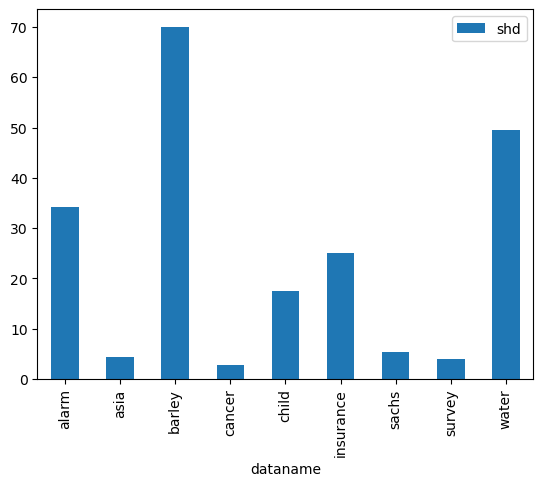

In [46]:
tmp_mean[tmp_mean['mode'] == 'n'].plot.bar(x='dataname', y='shd')

In [41]:
tmp_err = data.groupby(by=['dataname', 'folder', 'mode'])['etrue', 'espur', 'emiss', 'efals', 'time'].std().reset_index()
tmp_err.fillna(0, inplace=True)
tmp_err

/tmp/ipykernel_2507273/1266304420.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp_err = data.groupby(by=['dataname', 'folder', 'mode'])['etrue', 'espur', 'emiss', 'efals', 'time'].std().reset_index()


,dataname,folder,mode,etrue,espur,emiss,efals,time
0,alarm,m3_d1_n10,aL,2.828427,0.707107,2.828427,5.656854,2.911922
1,alarm,m3_d1_n10,aL-Re,1.414214,0.707107,4.242641,5.656854,1.876602
2,alarm,m3_d1_n10,aS,7.778175,0.707107,3.535534,4.242641,0.614390
3,alarm,m3_d1_n10,n,1.870829,0.836660,2.000000,1.000000,4.498133
4,asia,m3_d1_n10,aL,1.527525,0.577350,2.000000,0.577350,0.561797
5,asia,m3_d1_n10,aL-Re,2.000000,0.577350,1.000000,1.000000,0.853983
6,asia,m3_d1_n10,aS,0.000000,0.577350,0.000000,0.000000,0.786971
7,asia,m3_d1_n10,n,2.149935,0.421637,1.197219,1.100505,0.690604
8,barley,m3_d1_n10,aL,2.121320,2.121320,2.121320,0.000000,1.518628
9,barley,m3_d1_n10,aL-Re,3.535534,0.707107,4.949747,1.414214,6.517844
